### _Goal of project_

- 다음 분기에 어떤 게임을 설계할지에 대한 결정과정과 결론을 보여라.

- 단 배경지식이 없는 사람도 이해할 수 있도록 설명



---


### _반드시 들어가야 하는 내용_
- '지역에 따라서 선호하는 게임 장르가 다를까' 라는 질문에 대답. `

- '연도별 게임의 트렌드가 있을까' 라는 질문에 대답

- 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

---



학습 내용은 아래와 같다.
- Sprint 1 : EDA, Feature Engineering, Data Manipulation, Data Visualization

- Sprint 2 : Hypothesis Test, CI, Bayesian

- Sprint 3 : DR, PCA, Cluster




목표 : 출고량이 높은 게임 설계

가정 : 주어진 데이터외의 여러가지 사항들은 출고량에 영향을 주지 않는다고 가정


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.multivariate.manova import MANOVA
import scipy.stats as stats
import warnings


warnings.filterwarnings('ignore')

org_df=pd.read_csv('/content/gdrive/MyDrive/data/vgames2.csv',index_col = 0)

#가정 사항
# lot size 1만장
# 단위는 다 M  만장단위로 거래 
EDA

- 결측치 제거
- 판매량 float로 형변환 및 단위통일 (M)
- 연도 데이터 전처리
- 총 판매량 변수 생성



In [29]:
#데이터의 확인  
org_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


In [30]:
# 결측치 제거 # year :271,  Genre 50, publisher 58
# 결측치 제거 전: 16598 
# 결측치 제거 후: 16241  2% 가량 제거  
# Todo 결측치에 대한 ref 찾기
org_df.isnull().sum()
df=org_df.copy()
df=df.dropna()

In [31]:
#2020년  nintendo ds imagine makeup artist -> 2009년에 출시됨 
df.loc[6907,'Year']=2009

In [32]:
# 연도 기준으로 정렬
df=df.sort_values('Year').reset_index().drop('index',axis=1)


In [33]:
#연도 데이터 처리 및 문자형으로 변환, 
#판매량 float으로 변환

def to_M(data):
  if type(data) == str:
    if 'K' in data:
      data = pd.to_numeric(data.replace('K',''))
      data = data*0.001
    elif 'M' in data:
      data = pd.to_numeric(data.replace('M',''))
  return pd.to_numeric(data)    

# 연도가 x, xx 같이 되어있는 경우 19xx,200x,20xx 형태로 수정   
def year_cleansing(data):
  if data//10 < 3:
    data=data+2000
  elif  data//10 < 10: 
    data=data+1900
  return data  


df['Year'] =df['Year'].apply(int).apply(year_cleansing).apply(str) 
df['NA_Sales'] =df['NA_Sales'].apply(to_M) 
df['EU_Sales'] =df['EU_Sales'].apply(to_M) 
df['JP_Sales'] =df['JP_Sales'].apply(to_M) 
df['Other_Sales'] =df['Other_Sales'].apply(to_M) 



In [34]:
#총 판매량 
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales']+df['JP_Sales']+df['Other_Sales'] 


In [35]:
# 통계량  
df.describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
count,16241.000000,16241.000000,16241.000000,16241.000000,16241.000000
mean,0.265195,0.147378,0.078283,0.048234,0.539091
std,0.822431,0.508340,0.309272,0.189678,1.563905
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.040000,0.480000
max,41.490000,29.020000,10.220000,10.570000,82.740000


In [36]:
# 각 지역별 매출량이 가장 많았던 연도 도출 
NA_max_index=df['NA_Sales'].idxmax(axis=0)
EU_max_index=df['EU_Sales'].idxmax(axis=0)
JP_max_index=df['JP_Sales'].idxmax(axis=0)
OT_max_index=df['Other_Sales'].idxmax(axis=0)
TT_max_index=df['Total_Sales'].idxmax(axis=0)

# NA : 2006 EU: 2006 JP:1996, OT: 2004 
print(df.loc[NA_max_index,:],df.loc[EU_max_index,:], df.loc[JP_max_index,:], df.loc[OT_max_index,:],df.loc[TT_max_index,:])


Name           Wii Sports
Platform              Wii
Year                 2006
Genre              Sports
Publisher        Nintendo
NA_Sales            41.49
EU_Sales            29.02
JP_Sales             3.77
Other_Sales          8.46
Total_Sales         82.74
Name: 6913, dtype: object Name           Wii Sports
Platform              Wii
Year                 2006
Genre              Sports
Publisher        Nintendo
NA_Sales            41.49
EU_Sales            29.02
JP_Sales             3.77
Other_Sales          8.46
Total_Sales         82.74
Name: 6913, dtype: object Name           Pokemon Red/Pokemon Blue
Platform                             GB
Year                               1996
Genre                      Role-Playing
Publisher                      Nintendo
NA_Sales                          11.27
EU_Sales                           8.89
JP_Sales                          10.22
Other_Sales                           1
Total_Sales                       31.38
Name: 989, dtype: object Nam

In [37]:
df=df.sort_values('Year').reset_index().drop('index',axis=1)


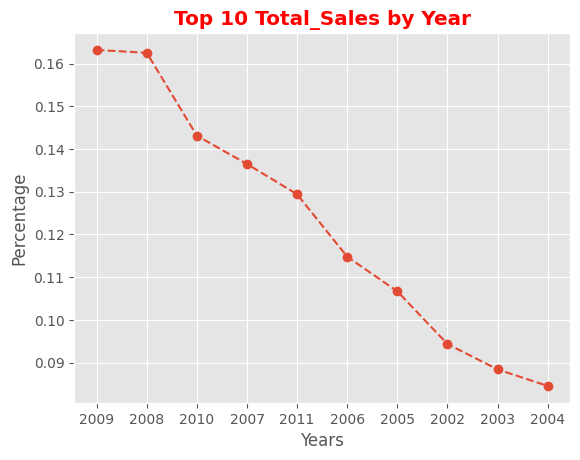

In [145]:
year=df.groupby(df['Year']).count()['Total_Sales']
plt.style.available
plt.style.use('ggplot')
figsize=(5,3)
plt.plot(year.sort_values(ascending = False).head(10)/df['Total_Sales'].sum(),'--o')
plt.ylabel('Percentage')
plt.xlabel('Years')
plt.title("Top 10 Total_Sales by Year",color='red',fontweight='bold')
plt.style.use('default')


In [110]:
year

Year
1980       8
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     262
1997     289
1998     377
1999     336
2000     348
2001     480
2002     826
2003     774
2004     740
2005     934
2006    1005
2007    1195
2008    1423
2009    1429
2010    1253
2011    1133
2012     652
2013     545
2014     580
2015     611
2016     342
2017       3
Name: Total_Sales, dtype: int64

wii sports

pokemon red /blue

GTA

In [39]:
#지역에 따라서 선호하는 게임 장르가 다를까'
NA_freq=df.sort_values('NA_Sales',ascending=False).reset_index().drop('index',axis=1).loc[:,['Genre',	'NA_Sales']]

EU_freq=df.sort_values('EU_Sales',ascending=False).reset_index().drop('index',axis=1).loc[:,['Genre',	'EU_Sales']]

JP_freq=df.sort_values('JP_Sales',ascending=False).reset_index().drop('index',axis=1).loc[:,['Genre',	'JP_Sales']]

OT_freq=df.sort_values('Other_Sales',ascending=False).reset_index().drop('index',axis=1).loc[:,['Genre',	'Other_Sales']]

TT_freq=df.sort_values('Total_Sales',ascending=False).reset_index().drop('index',axis=1).loc[:,['Genre',	'Total_Sales']]


In [40]:
NA_Genre = df.groupby('Genre')['NA_Sales'].sum().reset_index()
NA_Genre['Percentages'] = NA_Genre['NA_Sales']/sum(NA_Genre['NA_Sales'])*100
NA_Genre['Percentages'] = round(NA_Genre['Percentages'],2)


EU_Genre = df.groupby('Genre')['EU_Sales'].sum().reset_index()
EU_Genre['Percentages'] = EU_Genre['EU_Sales']/sum(EU_Genre['EU_Sales'])*100
EU_Genre['Percentages'] = round(EU_Genre['Percentages'],2)


JP_Genre = df.groupby('Genre')['JP_Sales'].sum().reset_index()
JP_Genre['Percentages'] = JP_Genre['JP_Sales']/sum(JP_Genre['JP_Sales'])*100



Other_Genre = df.groupby('Genre')['Other_Sales'].sum().reset_index()
Other_Genre['Percentages'] = Other_Genre['Other_Sales']/sum(Other_Genre['Other_Sales'])*100
Other_Genre['Percentages'] = round(Other_Genre['Percentages'],2)

Total_Genre = df.groupby('Genre')['Total_Sales'].sum().reset_index()
# NA_Genre['NA_Sales'] = round(group_genre_na['NA_Sales'],2)
Total_Genre['Percentages'] = Total_Genre['Total_Sales']/sum(Total_Genre['Total_Sales'])*100
Total_Genre['Percentages'] = round(Total_Genre['Percentages'],2)





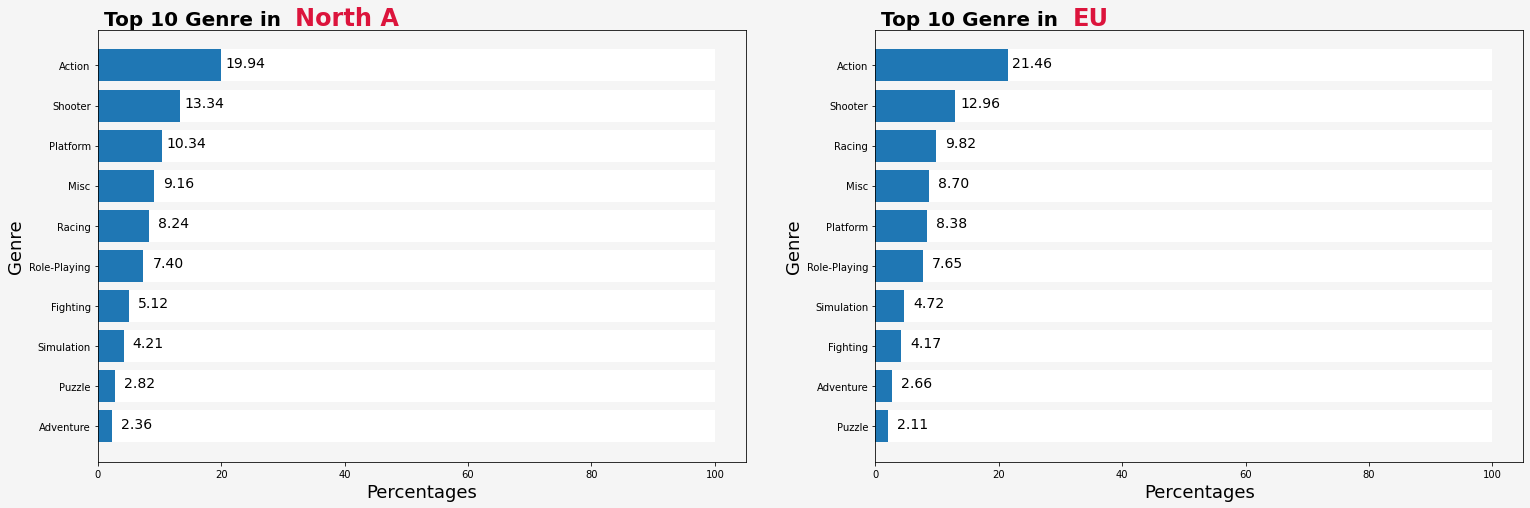

<Figure size 432x288 with 0 Axes>

In [41]:
group_genre_na = NA_Genre.head(10)
group_genre_na.sort_values(by='Percentages', inplace=True)
group_genre_na['Total'] = 100

fig = plt.figure(facecolor='whitesmoke')

axes1 = fig.add_axes([0, 0, 1.5, 1.5]) 
axes2 = fig.add_axes([1.8, 0, 1.5, 1.5]) 


axes1.barh(width=group_genre_na['Total'], y=group_genre_na['Genre'], color='white')
axes1.barh(width=group_genre_na['Percentages'], y=group_genre_na['Genre'])
axes1.text(1, 10, 'Top 10 Genre in', color='black', fontsize=20, fontweight='bold')
axes1.text(32, 10, 'North A', color='crimson', fontsize=24, fontweight='bold')
axes1.set_facecolor('whitesmoke')
axes1.set_xlabel('Percentages', fontsize=18, color='black')
axes1.set_ylabel('Genre', fontsize=18, color='black')
for p in axes1.patches[10:]:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes1.annotate('{:.2f}'.format(width), (4+ width, y + height*0.45), ha='center', fontsize=14, color='black')

group_genre_EU = EU_Genre.head(10)
group_genre_EU.sort_values(by='Percentages', inplace=True)
group_genre_EU['Total'] = 100

fig = plt.figure(facecolor='whitesmoke')


axes2.barh(width=group_genre_EU['Total'], y=group_genre_EU['Genre'], color='white')
axes2.barh(width=group_genre_EU['Percentages'], y=group_genre_EU['Genre'])
axes2.text(1, 10, 'Top 10 Genre in', color='black', fontsize=20, fontweight='bold')
axes2.text(32, 10, 'EU', color='crimson', fontsize=24, fontweight='bold')
axes2.set_facecolor('whitesmoke')
axes2.set_xlabel('Percentages', fontsize=18, color='black')
axes2.set_ylabel('Genre', fontsize=18, color='black')
for p in axes2.patches[10:]:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.2f}'.format(width), (4+ width, y + height*0.45), ha='center', fontsize=14, color='black')
plt.show()

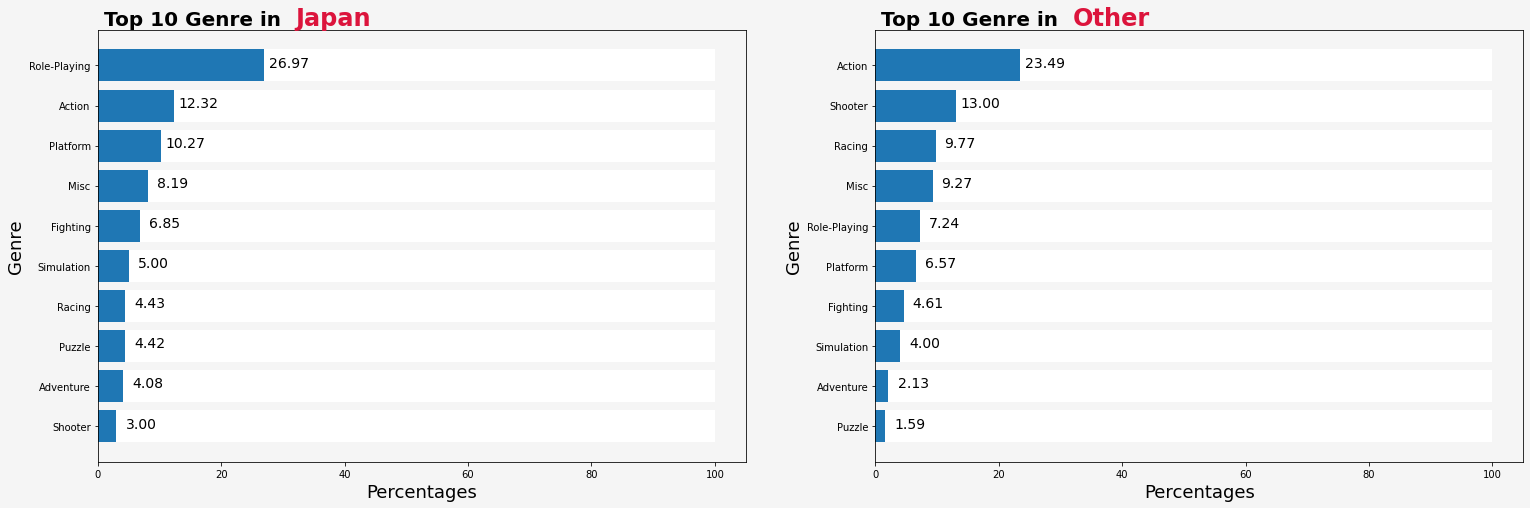

<Figure size 432x288 with 0 Axes>

In [42]:
group_genre_JP = JP_Genre.head(10)
group_genre_JP.sort_values(by='Percentages', inplace=True)
group_genre_JP['Total'] = 100

fig = plt.figure(facecolor='whitesmoke')

axes1 = fig.add_axes([0, 0, 1.5, 1.5]) 
axes2 = fig.add_axes([1.8, 0, 1.5, 1.5]) 



axes1.barh(width=group_genre_JP['Total'], y=group_genre_JP['Genre'], color='white')
axes1.barh(width=group_genre_JP['Percentages'], y=group_genre_JP['Genre'])
axes1.text(1, 10, 'Top 10 Genre in', color='black', fontsize=20, fontweight='bold')
axes1.text(32, 10, 'Japan', color='crimson', fontsize=24, fontweight='bold')
axes1.set_facecolor('whitesmoke')
axes1.set_xlabel('Percentages', fontsize=18, color='black')
axes1.set_ylabel('Genre', fontsize=18, color='black')
for p in axes1.patches[10:]:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes1.annotate('{:.2f}'.format(width), (4+ width, y + height*0.45), ha='center', fontsize=14, color='black')

group_genre_OT = Other_Genre.head(10)
group_genre_OT.sort_values(by='Percentages', inplace=True)
group_genre_OT['Total'] = 100

fig = plt.figure(facecolor='whitesmoke')

axes2.barh(width=group_genre_OT['Total'], y=group_genre_OT['Genre'], color='white')
axes2.barh(width=group_genre_OT['Percentages'], y=group_genre_OT['Genre'])
axes2.text(1, 10, 'Top 10 Genre in', color='black', fontsize=20, fontweight='bold')
axes2.text(32, 10, 'Other', color='crimson', fontsize=24, fontweight='bold')
axes2.set_facecolor('whitesmoke')
axes2.set_xlabel('Percentages', fontsize=18, color='black')
axes2.set_ylabel('Genre', fontsize=18, color='black')
for p in axes2.patches[10:]:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.2f}'.format(width), (4+ width, y + height*0.45), ha='center', fontsize=14, color='black')
plt.show()

In [43]:
sales_CT =pd.crosstab(index=[df.Genre],  columns=[df['NA_Sales']])

In [44]:

print("sales_CT",chi2_contingency(sales_CT, correction = False)[1])

sales_CT 4.767706829042129e-64


In [45]:
# 장르 one - hot encoding  
property_dummies=pd.get_dummies(df,columns=['Genre'])
property_dummies.columns
Anova_df = df.copy().drop('Genre',axis=1).merge(property_dummies)
Anova_df.head()


,Name,Platform,Year,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,Missile Command,2600,1980,Atari,2.56,0.17,0.0,0.03,2.76,0,0,0,0,0,0,0,0,1,0,0,0
1,Checkers,2600,1980,Atari,0.22,0.01,0.0,0.00,0.23,0,0,0,1,0,0,0,0,0,0,0,0
2,Boxing,2600,1980,Activision,0.72,0.04,0.0,0.01,0.77,0,0,1,0,0,0,0,0,0,0,0,0
3,Freeway,2600,1980,Activision,0.32,0.02,0.0,0.00,0.34,1,0,0,0,0,0,0,0,0,0,0,0
4,Bridge,2600,1980,Activision,0.25,0.02,0.0,0.00,0.27,0,0,0,1,0,0,0,0,0,0,0,0


In [50]:
# NA - 장르  Anova 



for i in Anova_df.columns[9:]:
  print(stats.f_oneway( Anova_df['NA_Sales'],Anova_df[i]))




F_onewayResult(statistic=83.84766222377888, pvalue=5.647941494163043e-20)
F_onewayResult(statistic=759.8724207232702, pvalue=2.3034413459321766e-165)
F_onewayResult(statistic=1023.575269205137, pvalue=3.689926054703597e-221)
F_onewayResult(statistic=552.0229207703101, pvalue=4.686277343423697e-121)
F_onewayResult(statistic=998.4099017533221, pvalue=7.445263742040084e-216)
F_onewayResult(statistic=1213.655109844734, pvalue=4.266821016064027e-261)
F_onewayResult(statistic=787.2615678575052, pvalue=3.5136846018491617e-171)
F_onewayResult(statistic=655.7108718058261, pvalue=3.3857219300304026e-143)
F_onewayResult(statistic=753.2563271960589, pvalue=5.863966684233245e-164)
F_onewayResult(statistic=1016.248851612852, pvalue=1.291227359479216e-219)
F_onewayResult(statistic=311.15309591077016, pvalue=2.580374141433668e-69)
F_onewayResult(statistic=1138.350178599457, pvalue=2.6569987572701106e-245)


In [51]:
# EU - 장르  Anova
for i in Anova_df.columns[9:]:
  print(stats.f_oneway( Anova_df['EU_Sales'],Anova_df[i]))



F_onewayResult(statistic=105.50490676855425, pvalue=1.0327886313704259e-24)
F_onewayResult(statistic=236.1035667545892, pvalue=4.27902550452932e-53)
F_onewayResult(statistic=486.9047896159822, pvalue=4.122772159122541e-107)
F_onewayResult(statistic=89.01865571466344, pvalue=4.162244603537815e-21)
F_onewayResult(statistic=460.3138575399852, pvalue=2.0812292116688357e-101)
F_onewayResult(statistic=704.1784520949561, pvalue=1.605951897504436e-153)
F_onewayResult(statistic=259.1117863225722, pvalue=4.4987652694136366e-58)
F_onewayResult(statistic=155.92766150591945, pvalue=1.0605404436564757e-35)
F_onewayResult(statistic=230.66114108754414, pvalue=6.452185254927106e-52)
F_onewayResult(statistic=479.10904146702734, pvalue=1.9348562202673495e-105)
F_onewayResult(statistic=1.4493914283626261, pvalue=0.22863440172023414)
F_onewayResult(statistic=614.7071556666828, pvalue=1.889791582509396e-134)


In [205]:
# JP - 장르  Anova
for i in Anova_df.columns[9:]:
  print(stats.f_oneway( Anova_df['JP_Sales'],Anova_df[i]))


F_onewayResult(statistic=934.4603381346601, pvalue=2.349821940085524e-202)
F_onewayResult(statistic=0.004221138120379258, pvalue=0.9481980580924716)
F_onewayResult(statistic=81.19019936330349, pvalue=2.1592574348442616e-19)
F_onewayResult(statistic=54.82047929444594, pvalue=1.3525742670515758e-13)
F_onewayResult(statistic=66.69905906520755, pvalue=3.2762227580373204e-16)
F_onewayResult(statistic=236.96910064816967, pvalue=2.779541476238874e-53)
F_onewayResult(statistic=1.0237593192880339, pvalue=0.31163648199515726)
F_onewayResult(statistic=12.986835346770322, pvalue=0.0003141574010990022)
F_onewayResult(statistic=0.027128478903341274, pvalue=0.8691754335308833)
F_onewayResult(statistic=76.82567505013276, pvalue=1.956285781143877e-18)
F_onewayResult(statistic=299.38906155782024, pvalue=8.926099921234098e-67)
F_onewayResult(statistic=165.32433973906984, pvalue=9.60760094178929e-38)


In [206]:
# OT - 장르  Anova
for i in Anova_df.columns[9:]:
  print(stats.f_oneway( Anova_df['Other_Sales'],Anova_df[i]))


F_onewayResult(statistic=1898.9370318902243, pvalue=0.0)
F_onewayResult(statistic=133.94989996683893, pvalue=6.443741853406294e-31)
F_onewayResult(statistic=1.9366407050487586, pvalue=0.1640432759351681)
F_onewayResult(statistic=385.2599645860791, pvalue=2.783726956983349e-85)
F_onewayResult(statistic=5.695769881512353, pvalue=0.01701153999865713)
F_onewayResult(statistic=41.790867228230184, pvalue=1.0301581704796813e-10)
F_onewayResult(statistic=110.85615828937239, pvalue=7.00392578584929e-26)
F_onewayResult(statistic=242.33664597117118, pvalue=1.915023809849025e-54)
F_onewayResult(statistic=139.8584785094711, pvalue=3.328819654810112e-32)
F_onewayResult(statistic=2.8294956314852104, pvalue=0.09255703323347106)
F_onewayResult(statistic=898.0195329972353, pvalue=1.1894352529753112e-194)
F_onewayResult(statistic=10.671017865908146, pvalue=0.0010894004689567262)


In [52]:

for i in Anova_df.columns[9:]:
  print(stats.f_oneway( Anova_df['Total_Sales'],Anova_df[i]))

F_onewayResult(statistic=718.8606047607242, pvalue=1.206467569291026e-156)
F_onewayResult(statistic=1370.9697956629143, pvalue=5.640866705947102e-294)
F_onewayResult(statistic=1548.3970595209196, pvalue=0.0)
F_onewayResult(statistic=1213.8624675577744, pvalue=3.8606781245444485e-261)
F_onewayResult(statistic=1532.288909625545, pvalue=0.0)
F_onewayResult(statistic=1665.4645047216736, pvalue=0.0)
F_onewayResult(statistic=1390.383787897974, pvalue=5.06549973035172e-298)
F_onewayResult(statistic=1294.5881032204331, pvalue=4.961369846178897e-278)
F_onewayResult(statistic=1366.2407561714097, pvalue=5.463134712222419e-293)
F_onewayResult(statistic=1543.7233682124813, pvalue=0.0)
F_onewayResult(statistic=999.731917799965, pvalue=3.918289005384853e-216)
F_onewayResult(statistic=1620.0050968187936, pvalue=0.0)


In [27]:
#범주형 데이터의 변형¶
#대부분의 데이터 분석 모형은 숫자만 입력으로 받을 수 있기 때문에 범주형 데이터는 숫자로 변환해야 한다. 범주형 데이터를 숫자로 변환하는 방법은 두가지다.



In [ ]:
#plattfoam genre 결합해서 새로운 변수 

In [87]:
Trend_df = df.copy()
Trend_df['Trend'] =Trend_df['Platform']+'_'+Trend_df['Genre']

In [ ]:
NA_trend=[]
EU_trend=[]
JP_trend=[]
Other_trend=[]
Total_trend=[]
for i in Trend_df:
    val=Trend_df[Trend_df.Trend==i]
    NA_trend.append(Trend_df.NA_Sales.sum())
    EU_trend.append(Trend_df.EU_Sales.sum())
    JP_trend.append(Trend_df.JP_Sales.sum())
    Other_trend.append(Trend_df.Other_Sales.sum())

<Figure size 1080x720 with 0 Axes>

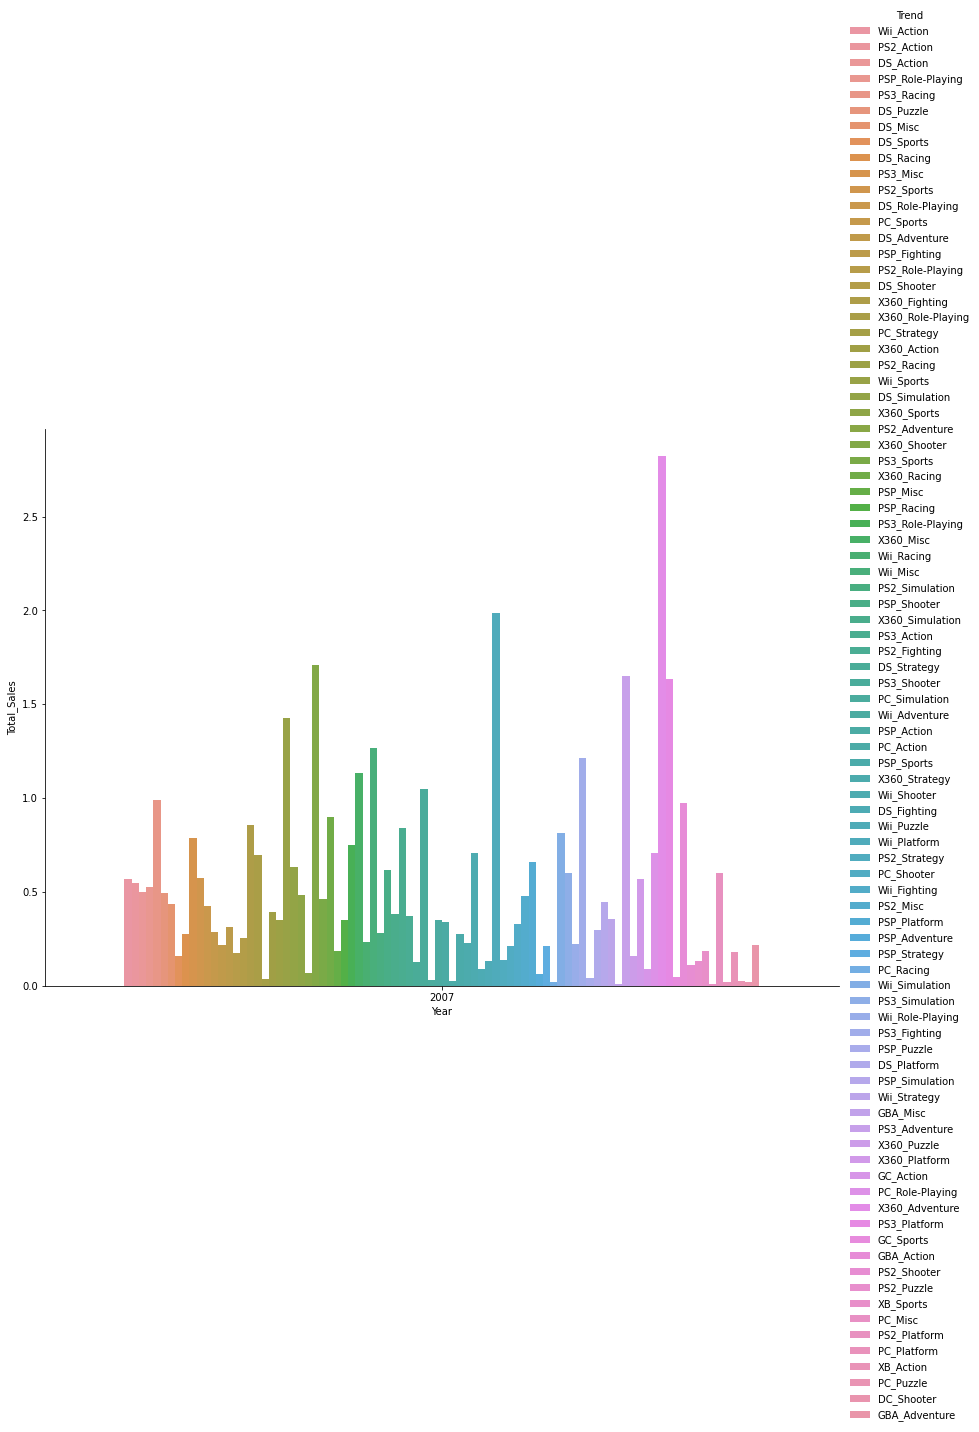

In [ ]:
first_filter=pd.to_numeric(Trend_df.Year)>2006
second_filter=pd.to_numeric(Trend_df.Year)<2008
new_data=Trend_df[first_filter&second_filter]

plt.figure(figsize=(15,10))
sns.catplot(x="Year",y="Total_Sales",kind="bar",
            hue="Trend",
            data=new_data,
            edgecolor=None,
            height=8.27, aspect=11.7/8.27,ci=None)
plt.show()

In [53]:
df[(df['Total_Sales'].max() ==df['Total_Sales'])]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
6479,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74


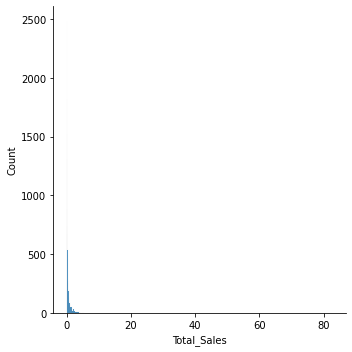

In [54]:
sns.displot(df['Total_Sales'])

In [76]:
Anova_df.head()

,Name,Platform,Year,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,Missile Command,2600,1980,Atari,2.56,0.17,0.0,0.03,2.76,0,0,0,0,0,0,0,0,1,0,0,0
1,Checkers,2600,1980,Atari,0.22,0.01,0.0,0.00,0.23,0,0,0,1,0,0,0,0,0,0,0,0
2,Boxing,2600,1980,Activision,0.72,0.04,0.0,0.01,0.77,0,0,1,0,0,0,0,0,0,0,0,0
3,Freeway,2600,1980,Activision,0.32,0.02,0.0,0.00,0.34,1,0,0,0,0,0,0,0,0,0,0,0
4,Bridge,2600,1980,Activision,0.25,0.02,0.0,0.00,0.27,0,0,0,1,0,0,0,0,0,0,0,0


In [214]:
# NA_list=Anova_df.loc[:,Anova_df.columns[9:]]
print(stats.f_oneway( Anova_df['NA_Sales'],Anova_df['Genre_Action'], Anova_df['Genre_Adventure'], Anova_df['Genre_Fighting'],
                     Anova_df['Genre_Misc'],Anova_df['Genre_Puzzle'],Anova_df['Genre_Platform'],Anova_df['Genre_Racing'],
                     Anova_df['Genre_Role-Playing'],Anova_df['Genre_Shooter'],Anova_df['Genre_Simulation'],Anova_df['Genre_Sports'],
                    Anova_df['Genre_Strategy']))

print(stats.f_oneway( Anova_df['EU_Sales'],Anova_df['Genre_Action'], Anova_df['Genre_Adventure'], Anova_df['Genre_Fighting'],
                     Anova_df['Genre_Misc'],Anova_df['Genre_Puzzle'],Anova_df['Genre_Platform'],Anova_df['Genre_Racing'],
                     Anova_df['Genre_Role-Playing'],Anova_df['Genre_Shooter'],Anova_df['Genre_Simulation'],Anova_df['Genre_Sports'],
                    Anova_df['Genre_Strategy']))

print(stats.f_oneway( Anova_df['JP_Sales'],Anova_df['Genre_Action'], Anova_df['Genre_Adventure'], Anova_df['Genre_Fighting'],
                     Anova_df['Genre_Misc'],Anova_df['Genre_Puzzle'],Anova_df['Genre_Platform'],Anova_df['Genre_Racing'],
                     Anova_df['Genre_Role-Playing'],Anova_df['Genre_Shooter'],Anova_df['Genre_Simulation'],Anova_df['Genre_Sports'],
                    Anova_df['Genre_Strategy']))

print(stats.f_oneway( Anova_df['Other_Sales'],Anova_df['Genre_Action'], Anova_df['Genre_Adventure'], Anova_df['Genre_Fighting'],
                     Anova_df['Genre_Misc'],Anova_df['Genre_Puzzle'],Anova_df['Genre_Platform'],Anova_df['Genre_Racing'],
                     Anova_df['Genre_Role-Playing'],Anova_df['Genre_Shooter'],Anova_df['Genre_Simulation'],Anova_df['Genre_Sports'],
                    Anova_df['Genre_Strategy']))

F_onewayResult(statistic=616.668424385109, pvalue=0.0)
F_onewayResult(statistic=431.75273770988923, pvalue=0.0)
F_onewayResult(statistic=435.87237349476493, pvalue=0.0)
F_onewayResult(statistic=485.00040979500034, pvalue=0.0)


In [88]:
Trend_df['Trend'].value_counts

<bound method IndexOpsMixin.value_counts of 0            2600_Shooter
1               2600_Misc
2           2600_Fighting
3             2600_Action
4               2600_Misc
               ...       
16236        PS3_Fighting
16237           PC_Racing
16238    PS4_Role-Playing
16239          PSV_Action
16240    PSV_Role-Playing
Name: Trend, Length: 16241, dtype: object>

In [89]:
Trend_df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Trend
0,Missile Command,2600,1980,Shooter,Atari,2.56,0.17,0.0,0.03,2.76,2600_Shooter
1,Checkers,2600,1980,Misc,Atari,0.22,0.01,0.0,0.00,0.23,2600_Misc
2,Boxing,2600,1980,Fighting,Activision,0.72,0.04,0.0,0.01,0.77,2600_Fighting
3,Freeway,2600,1980,Action,Activision,0.32,0.02,0.0,0.00,0.34,2600_Action
4,Bridge,2600,1980,Misc,Activision,0.25,0.02,0.0,0.00,0.27,2600_Misc


In [90]:
Trend_df.groupby('Trend').sum()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Trend,,,,,
2600_Action,24.63,1.47,0.00,0.21,26.31
2600_Adventure,0.38,0.02,0.00,0.00,0.40
2600_Fighting,0.72,0.04,0.00,0.01,0.77
2600_Misc,3.34,0.20,0.00,0.03,3.57
2600_Platform,12.38,0.72,0.00,0.16,13.26
...,...,...,...,...,...
XOne_Role-Playing,5.56,3.06,0.01,0.83,9.46
XOne_Shooter,31.78,15.27,0.16,4.38,51.59
XOne_Simulation,0.28,0.21,0.00,0.05,0.54


In [91]:
Trend_df.groupby('Name').sum().Total_Sales.sort_values(ascending=False).head(40)

Name
Wii Sports                                      82.74
Grand Theft Auto V                              55.92
Super Mario Bros.                               45.31
Tetris                                          35.84
Mario Kart Wii                                  35.83
Wii Sports Resort                               33.00
Pokemon Red/Pokemon Blue                        31.38
Call of Duty: Modern Warfare 3                  30.84
New Super Mario Bros.                           30.01
Call of Duty: Black Ops II                      29.73
Call of Duty: Black Ops                         29.41
Wii Play                                        29.01
New Super Mario Bros. Wii                       28.61
Duck Hunt                                       28.31
Call of Duty: Ghosts                            27.37
Super Mario World                               26.09
Call of Duty: Black Ops 3                       25.30
Call of Duty: Modern Warfare 2                  25.10
Nintendogs             

In [92]:
#연도별 게임트렌드? 
# 연도별로 많이 나오는 게임 
#가설검정  


property_dummies=pd.get_dummies(Trend_df,columns=['Trend'])
property_dummies.columns
Anova_T_df = Trend_df.copy().drop('Trend',axis=1).merge(property_dummies)


In [93]:
year_Trend=Anova_T_df.groupby('Year').sum().Trend_2600_Action

for i in Anova_T_df.columns[11:12]:
  #year_Trend = year_Trend + Anova_T_df.groupby('Year').sum().i
  # print(Anova_T_df.groupby('Year').sum().Trend_2600_Adventure)
  # print(Anova_T_df.groupby('Year').sum().i)
  print(i)

year_Trend
#Anova_T_df.groupby('Trend_2600_Action').sum().Year
# year_Trend=Anova_T_df.groupby('Trend_2600_Action').sum().Year
# b=Anova_T_df.groupby('Year').sum().Trend_2600_Action+Anova_T_df.groupby('Year').sum().Trend_2600_Action
# Anova_T_df.groupby('Year').sum().
# year_Trend

Trend_2600_Adventure


Year
1980     1
1981    25
1982    18
1983     7
1984     0
1985     0
1986     0
1987     2
1988     1
1989     1
1990     0
1991     0
1992     0
1993     0
1994     0
1995     0
1996     0
1997     0
1998     0
1999     0
2000     0
2001     0
2002     0
2003     0
2004     0
2005     0
2006     0
2007     0
2008     0
2009     0
2010     0
2011     0
2012     0
2013     0
2014     0
2015     0
2016     0
2017     0
Name: Trend_2600_Action, dtype: uint8

In [94]:
for i in Anova_df.columns[9:]:
  print(stats.f_oneway( Anova_df['EU_Sales'],Anova_df[i]))



F_onewayResult(statistic=105.50490676855425, pvalue=1.0327886313704259e-24)
F_onewayResult(statistic=236.1035667545892, pvalue=4.27902550452932e-53)
F_onewayResult(statistic=486.9047896159822, pvalue=4.122772159122541e-107)
F_onewayResult(statistic=89.01865571466344, pvalue=4.162244603537815e-21)
F_onewayResult(statistic=460.3138575399852, pvalue=2.0812292116688357e-101)
F_onewayResult(statistic=704.1784520949561, pvalue=1.605951897504436e-153)
F_onewayResult(statistic=259.1117863225722, pvalue=4.4987652694136366e-58)
F_onewayResult(statistic=155.92766150591945, pvalue=1.0605404436564757e-35)
F_onewayResult(statistic=230.66114108754414, pvalue=6.452185254927106e-52)
F_onewayResult(statistic=479.10904146702734, pvalue=1.9348562202673495e-105)
F_onewayResult(statistic=1.4493914283626261, pvalue=0.22863440172023414)
F_onewayResult(statistic=614.7071556666828, pvalue=1.889791582509396e-134)


In [95]:
Trend_df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Trend
0,Missile Command,2600,1980,Shooter,Atari,2.56,0.17,0.0,0.03,2.76,2600_Shooter
1,Checkers,2600,1980,Misc,Atari,0.22,0.01,0.0,0.00,0.23,2600_Misc
2,Boxing,2600,1980,Fighting,Activision,0.72,0.04,0.0,0.01,0.77,2600_Fighting
3,Freeway,2600,1980,Action,Activision,0.32,0.02,0.0,0.00,0.34,2600_Action
4,Bridge,2600,1980,Misc,Activision,0.25,0.02,0.0,0.00,0.27,2600_Misc


In [96]:
Trend_CT = pd.crosstab(index=[Trend_df.Year],  columns=[Trend_df['Trend']])

In [209]:
#연도 트랜트 카이제곱 검정
print("Year-Trend " , chi2_contingency(Trend_CT, correction = False)[1]) 

Year-Trend  0.0


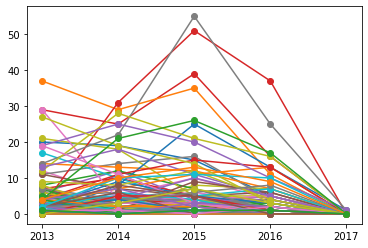

<Figure size 432x288 with 0 Axes>

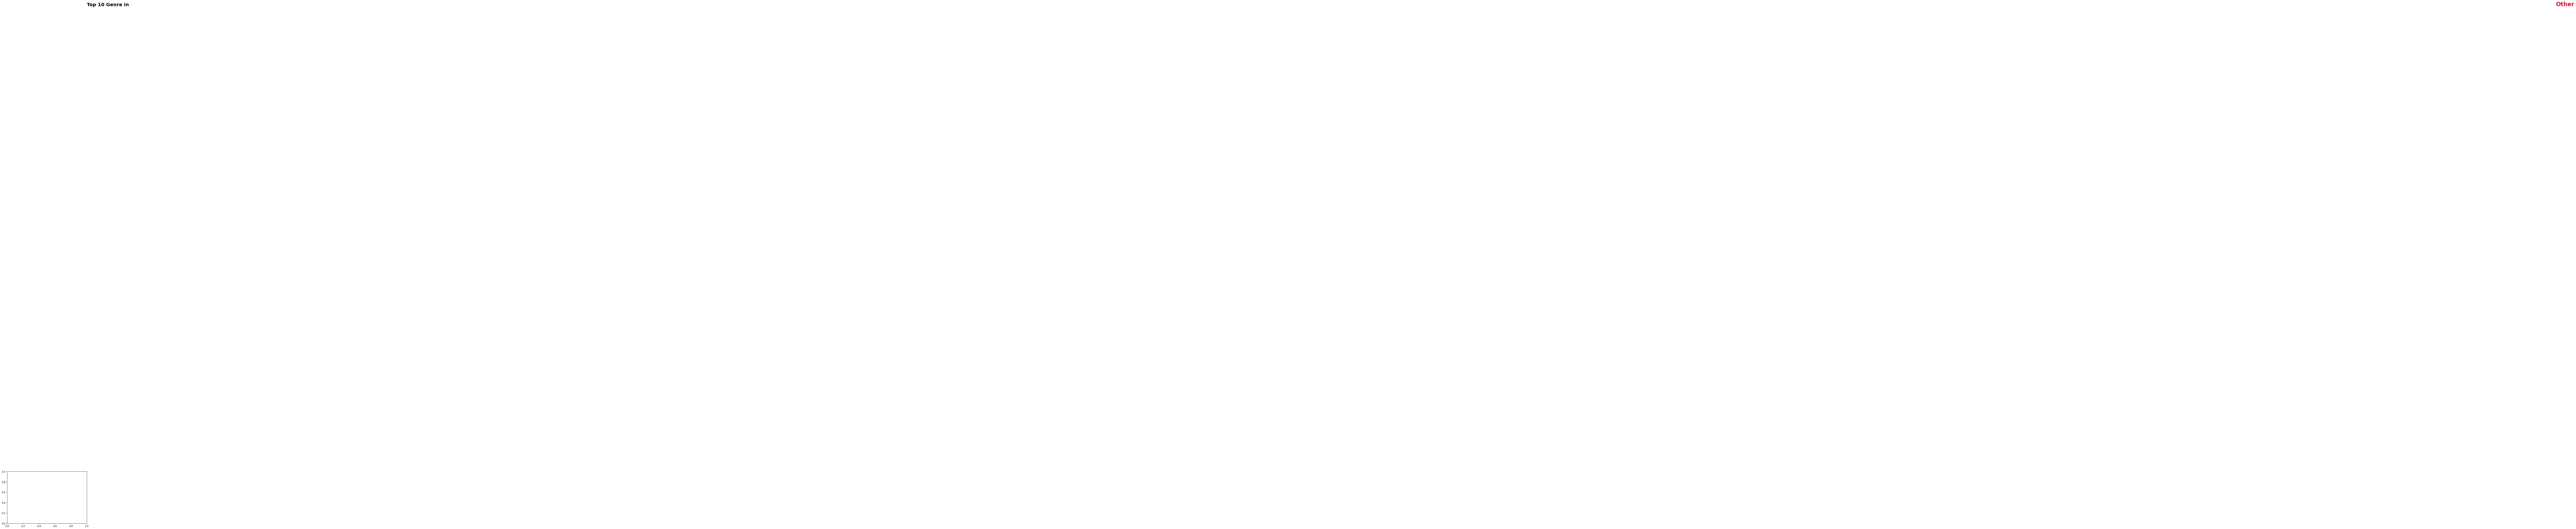

<Figure size 432x288 with 0 Axes>

In [98]:
#데이터수가가장 많은 연도 2개 뽑아서 트랜트 그려보자

plt.plot(Trend_CT.tail(5),marker='o')
plt.title('')
plt.figure(facecolor='whitesmoke')
# sns.set_style('white')
plt.show()
plt.text(1, 10, 'Top 10 Genre in', color='black', fontsize=20, fontweight='bold')
plt.text(32, 10, 'Other', color='crimson', fontsize=24, fontweight='bold')
fig = plt.figure(facecolor='whitesmoke')
# sns.set_style('white')


axes2.set_facecolor('whitesmoke')
axes2.set_xlabel('Percentages', fontsize=18, color='black')
axes2.set_ylabel('Genre', fontsize=18, color='black')
for p in axes2.patches[10:]:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.2f}'.format(width), (4+ width, y + height*0.45), ha='center', fontsize=14, color='black')
plt.show()

In [146]:
Trend_CT.tail(5)

Trend,2600_Action,2600_Adventure,2600_Fighting,2600_Misc,2600_Platform,2600_Puzzle,2600_Racing,2600_Shooter,2600_Simulation,2600_Sports,3DO_Adventure,3DO_Puzzle,3DO_Simulation,3DS_Action,3DS_Adventure,3DS_Fighting,3DS_Misc,3DS_Platform,3DS_Puzzle,3DS_Racing,3DS_Role-Playing,3DS_Shooter,3DS_Simulation,3DS_Sports,3DS_Strategy,DC_Action,DC_Adventure,DC_Fighting,DC_Platform,DC_Racing,DC_Role-Playing,DC_Shooter,DC_Simulation,DC_Sports,DS_Action,DS_Adventure,DS_Fighting,DS_Misc,DS_Platform,DS_Puzzle,...,Wii_Role-Playing,Wii_Shooter,Wii_Simulation,Wii_Sports,Wii_Strategy,X360_Action,X360_Adventure,X360_Fighting,X360_Misc,X360_Platform,X360_Puzzle,X360_Racing,X360_Role-Playing,X360_Shooter,X360_Simulation,X360_Sports,X360_Strategy,XB_Action,XB_Adventure,XB_Fighting,XB_Misc,XB_Platform,XB_Puzzle,XB_Racing,XB_Role-Playing,XB_Shooter,XB_Simulation,XB_Sports,XB_Strategy,XOne_Action,XOne_Adventure,XOne_Fighting,XOne_Misc,XOne_Platform,XOne_Racing,XOne_Role-Playing,XOne_Shooter,XOne_Simulation,XOne_Sports,XOne_Strategy
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013,0,0,0,0,0,0,0,0,0,0,0,0,0,29,6,2,12,7,2,0,20,1,5,3,3,0,0,0,0,0,0,0,0,0,3,1,0,1,2,0,...,0,0,1,2,1,27,1,2,4,4,0,4,2,19,2,9,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2,1,2,0,2,1,4,1
2014,0,0,0,0,0,0,0,0,0,0,0,0,0,25,12,2,5,2,2,0,19,0,4,4,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,19,6,4,2,0,0,7,6,11,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,21,5,0,8,1,3,3,10,0,10,0
2015,0,0,0,0,0,0,0,0,0,0,0,0,0,39,4,2,10,4,4,0,15,0,3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14,4,1,2,1,0,2,0,3,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,26,5,3,5,0,6,7,11,1,13,1
2016,0,0,0,0,0,0,0,0,0,0,0,0,0,16,4,1,4,2,0,0,5,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,17,1,2,0,2,8,3,10,1,9,1
2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


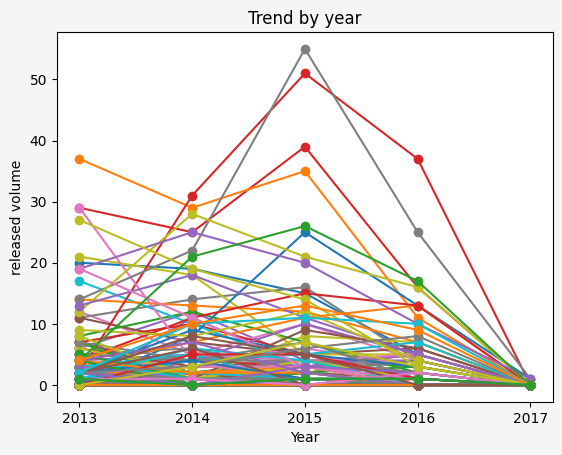

In [157]:

plt.figure(facecolor='whitesmoke')
# sns.set_style('white')
plt.title('Trend by year')
plt.xlabel('Year')
plt.ylabel('released volume')
plt.plot(Trend_CT.tail(5),marker='o')

plt.show()
# sns.set_style('white')

In [99]:
Top10_sales=df.sort_values('Total_Sales',ascending=False).head(10)


In [100]:
Top10_sales = Top10_sales.drop(['NA_Sales'	,'EU_Sales'	,'JP_Sales','Other_Sales'],axis=1)


In [101]:
Top10_sales.reset_index().drop('index',axis=1)


,Name,Platform,Year,Genre,Publisher,Total_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.83
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,31.38
5,Tetris,GB,1989,Puzzle,Nintendo,30.26
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,30.01
7,Wii Play,Wii,2006,Misc,Nintendo,29.01
8,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.61
9,Duck Hunt,NES,1984,Shooter,Nintendo,28.31


In [103]:
Top10_sales['Percentages'] = Top10_sales['Total_Sales'] / df['Total_Sales'].sum()

In [105]:
Top10_sales

,Name,Platform,Year,Genre,Publisher,Total_Sales,Percentages
6479,Wii Sports,Wii,2006,Sports,Nintendo,82.74,0.009450
130,Super Mario Bros.,NES,1985,Platform,Nintendo,40.24,0.004596
9528,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.83,0.004092
9735,Wii Sports Resort,Wii,2009,Sports,Nintendo,33.00,0.003769
837,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,31.38,0.003584
202,Tetris,GB,1989,Puzzle,Nintendo,30.26,0.003456
6615,New Super Mario Bros.,DS,2006,Platform,Nintendo,30.01,0.003428
6574,Wii Play,Wii,2006,Misc,Nintendo,29.01,0.003313
9840,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.61,0.003268
108,Duck Hunt,NES,1984,Shooter,Nintendo,28.31,0.003233


In [161]:
Top10_sales2=Trend_df.sort_values('Total_Sales',ascending=False).head(10)
Top10_sales2 = Top10_sales2.drop(['Genre','NA_Sales'	,'EU_Sales'	,'JP_Sales','Other_Sales'],axis=1)
Top10_sales2.reset_index().drop('index',axis=1)

,Name,Platform,Year,Publisher,Total_Sales,Trend
0,Wii Sports,Wii,2006,Nintendo,82.74,Wii_Sports
1,Super Mario Bros.,NES,1985,Nintendo,40.24,NES_Platform
2,Mario Kart Wii,Wii,2008,Nintendo,35.83,Wii_Racing
3,Wii Sports Resort,Wii,2009,Nintendo,33.00,Wii_Sports
4,Pokemon Red/Pokemon Blue,GB,1996,Nintendo,31.38,GB_Role-Playing
5,Tetris,GB,1989,Nintendo,30.26,GB_Puzzle
6,New Super Mario Bros.,DS,2006,Nintendo,30.01,DS_Platform
7,Wii Play,Wii,2006,Nintendo,29.01,Wii_Misc
8,New Super Mario Bros. Wii,Wii,2009,Nintendo,28.61,Wii_Platform
9,Duck Hunt,NES,1984,Nintendo,28.31,NES_Shooter


In [164]:
Top10_sales2

,Name,Platform,Year,Publisher,Total_Sales,Trend
6479,Wii Sports,Wii,2006,Nintendo,82.74,Wii_Sports
130,Super Mario Bros.,NES,1985,Nintendo,40.24,NES_Platform
9528,Mario Kart Wii,Wii,2008,Nintendo,35.83,Wii_Racing
9735,Wii Sports Resort,Wii,2009,Nintendo,33.00,Wii_Sports
837,Pokemon Red/Pokemon Blue,GB,1996,Nintendo,31.38,GB_Role-Playing
202,Tetris,GB,1989,Nintendo,30.26,GB_Puzzle
6615,New Super Mario Bros.,DS,2006,Nintendo,30.01,DS_Platform
6574,Wii Play,Wii,2006,Nintendo,29.01,Wii_Misc
9840,New Super Mario Bros. Wii,Wii,2009,Nintendo,28.61,Wii_Platform
108,Duck Hunt,NES,1984,Nintendo,28.31,NES_Shooter


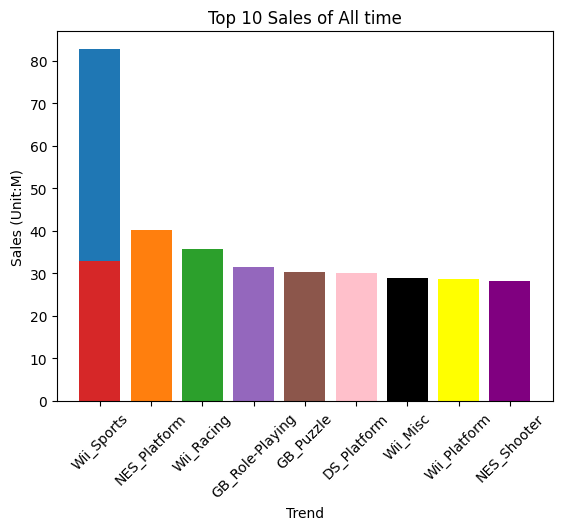

In [196]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown','pink','black','yellow','purple']

plt.bar(Top10_sales2['Trend'],Top10_sales2['Total_Sales'],color=colors)
plt.xticks(rotation=45) 
plt.xlabel('Trend')
plt.ylabel('Sales (Unit:M)')
plt.title('Top 10 Sales of All time')
plt.show()

In [215]:
year

Year
1980       8
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     262
1997     289
1998     377
1999     336
2000     348
2001     480
2002     826
2003     774
2004     740
2005     934
2006    1005
2007    1195
2008    1423
2009    1429
2010    1253
2011    1133
2012     652
2013     545
2014     580
2015     611
2016     342
2017       3
Name: Total_Sales, dtype: int64

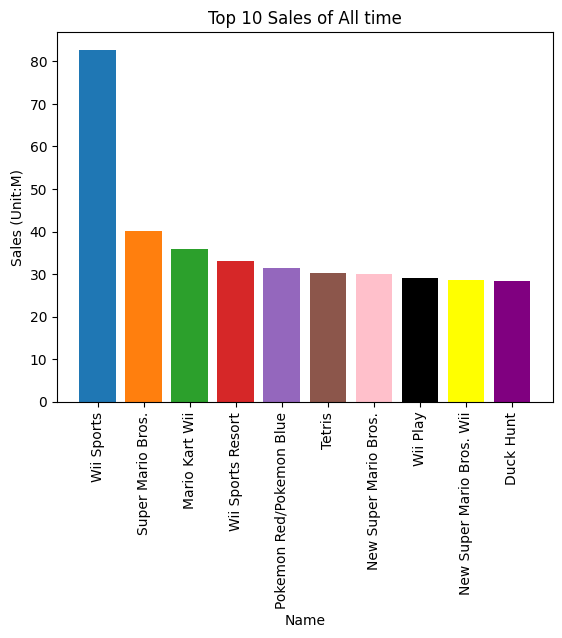

In [202]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown','pink','black','yellow','purple']

plt.bar(Top10_sales2['Name'],Top10_sales2['Total_Sales'],color=colors)
plt.xticks(rotation=90) 
plt.xlabel('Name')
plt.ylabel('Sales (Unit:M)')
plt.title('Top 10 Sales of All time')
plt.show()

In [203]:
year

Year
1980       8
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     262
1997     289
1998     377
1999     336
2000     348
2001     480
2002     826
2003     774
2004     740
2005     934
2006    1005
2007    1195
2008    1423
2009    1429
2010    1253
2011    1133
2012     652
2013     545
2014     580
2015     611
2016     342
2017       3
Name: Total_Sales, dtype: int64